In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
import tensorflow as tf

# 1. Hello world

当在 Tensorflow 里执行一个操作时，需要处于一个 Session 上下文里。一个 Session 维护了一个计算图，这个计算图包含张量以及各种操作。当你创建张量和操作时，它们并没有被立即执行，而是在等待别的操作和张量被添加到计算图中。仅在最后需要得到 Session 的值时猜真正做计算。这种延迟计算的方法提供了额外的并行和优化的机会，因为 Tensorflow 知道所有的操作之后可以决定如何组合各种操作，以及要在哪里执行这些操作。

`tf.constant` 构建给定形状的张量，并将 `constant` 运算作用于其上，用给定的常数填充这个张量。类似于 `numpy` 的 `array` 或 `full`。

`tf.add` 把“加”这个操作放进计算图里。此时计算的结果还不知道。
`eval` 执行计算。

`output.eval` 如果被放到 `tf.Session()` 之外，是无法执行的，会报错。

tensorflow 里的运算是强类型的，比如整数不能和浮点数相加。

In [2]:
with tf.Session():
  input1 = tf.constant([1.0, 1.0, 1.0, 1.0])
  input2 = tf.constant([2.0, 2.0, 2.0, 2.0])
  output = tf.add(input1, input2)
  result = output.eval()
  print result

[ 3.  3.  3.  3.]


In [23]:
with tf.Session():
    input1 = tf.constant(1.0, shape=[4], name='const1')
    input2 = tf.constant(2.0, shape=[4], name='const2')
    input3 = tf.constant(3.0, shape=[4], name='const3')
    output = tf.add(tf.add(input1,input2), tf.mul(input2,input3))
    print input1.name
    print output.eval()

 const1_8:0
[ 9.  9.  9.  9.]


In [34]:
with tf.Session():
    input1 = tf.constant(1.0, shape=[3,4])
    input2 = tf.constant(np.reshape(np.arange(1.0,13.0,dtype=np.float32),
                                    (3,4)))
    input3 = tf.to_float(tf.reshape(tf.range(1, 13), (3,4)))
    output = tf.add(tf.add(input1, input2), input3)
    print output.eval()

[[  3.   5.   7.   9.]
 [ 11.  13.  15.  17.]
 [ 19.  21.  23.  25.]]


在下面这段代码中，`input_features` 是个 1 行 4 列的矩阵，`weights` 是个 4 行 2 列的矩阵，前者乘以后者得到一个 1 行 2 列的矩阵。

In [75]:
for i in xrange(2):
    with tf.Session():
        input_features = tf.constant(np.reshape([1,0,0,1],
                                                (1,4)).astype(np.float32))
        weights = tf.constant(np.random.randn(4,2).astype(np.float32))
        output = tf.matmul(input_features, weights)
        print 'input:'
        print input_features.eval()
        print 'output:'
        print output.eval()

input:
[[ 1.  0.  0.  1.]]
output:
[[-0.32475945 -2.9975462 ]]
input:
[[ 1.  0.  0.  1.]]
output:
[[ 3.34516263 -1.74908459]]


下面的代码中，`tf.Variable` 定义出变量。`tf.assign` 定义出一些操作，但并不执行。`for` 循环内部重复执行这些操作。

In [77]:
with tf.Session() as sess:
    total = tf.Variable(tf.zeros([1,2]))
    weights = tf.Variable(tf.random_uniform([1,2]))
    
    tf.initialize_all_variables().run()
    
    update_weights = tf.assign(weights,
                               tf.random_uniform([1,2], -1.0, 1.0))
    update_total = tf.assign(total, tf.add(total, weights))
    
    for _ in range(5):
        sess.run(update_weights)
        sess.run(update_total)
        print weights.eval(), total.eval()

[[ 0.58959675 -0.9847672 ]] [[ 0.58959675 -0.9847672 ]]
[[-0.27734828  0.11410642]] [[ 0.31224847 -0.87066078]]
[[ 0.3493979   0.72860265]] [[ 0.66164637 -0.14205813]]
[[ 0.22302318 -0.85259032]] [[ 0.88466954 -0.99464846]]
[[ 0.73373866  0.63410902]] [[ 1.6184082  -0.36053944]]


# 2. 最简单的“神经网络”

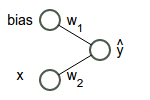

In [80]:
from IPython.display import Image
import base64
Image(data=base64.decodestring("iVBORw0KGgoAAAANSUhEUgAAAJYAAABkCAYAAABkW8nwAAAO90lEQVR4Xu2dT5Dc1J3Hv+YQT8VJZUhVdprLWs4FTSrGGv4ql9CuHBCH4GaTFCLZwnIcjOAy8l6Q/1SlU4XHcg6xJgtY2OOik2KxSGoTGWrXzYFC2T2MDAtWitRavmQ0e9k2SYGowom4hNRPtqA9TE+rW3/cPfPepcfup6f3fu/Tv9/T+/PVpo8//vhjsMQsULAFNjGwCrYoKy6xAAOLgVCKBRhYpZiVFcrAYgyUYgEGVilmZYUysBgDpViAgVWKWVmhDCzGQCkWGEuwrly5gtf++zW887/vYOn/lnD5T5cT40x9ZQrb/nEbxDtFiHeI2LJlSylGY4X2t8BYgUVAvfzqy3i5/TI+vPLhmq37wpYv4AHpATxw3wMMsP4cFJ5jbMAiqA4eOYg/Lv8xMcL26e34+vTXk8+vbv1q8n/03TsX38EfLv4h+aRE380dmmNwFY7O2gWOBVgE1Y/2/yjxUls+vwXaY1oS7tZK3v94MJ8zceUvV0Dea+H4AoOrQrhGHqxuT0Xjp0P7D2HqH6Yymejyu5dx5PiRZBxGnmt+bj7TdSxTfgv0ASuAzglwmyE8pfbZu3VaEDkDdT+AweevzGolvPjvL+LMb84knmr+yHxmqNKyCK7ZQ7OJ5yIo+3m6clqx8UrNB1bso2W64FQN9cnijdcdAvNAQWGRPBcLicX3Ua8S84FVcj3PnjuLhRcWkgH63OG5XHc7+NTBZEBP47NvffNbucpiF/e3QCaw2g0NfNvES5c+wtQ9u2G0LCj8BLAiFEaeBU0zYJ9fxkfYjKl7FZgtCzIHIA7QUmXov/g9LmMztt6rwLBMyFROj3TkZ0fgveXh4X96GN//zvf7t2aNHGlI7VlW0pYmRC+AKUwAsQu5thOuvIjQEjGBGJ7CQYptdOw6etc6VzXXzcUZwJrGseWt2P28DV2I4OgyDgQKFgMTYtQ1xqq10eDuR6j8Fi1NxGTkwpAfRos7h05bQscQIFgibEeHMBHCVhs4EBtY8lQQd6ulvbN78e6f302mC7Z/bXsuo9NkKk1X9PZ+IUyeR0sN4GscYl8DPzOP5VuPYynQwMU+dL4O3wzRbpQQ93O1bvQuzgRWS0p/tQA6Nuqcilq7A5u3Px28T7qw7BB1VUHqhEKTB2+pCAIVHZVD3dPgujpE6peOBzesQRS5nr/+b//g24nF7JN27qkCGq/J++RknHXm5JlVeiKGr/MQPQMdV0ZkCRBbNUwEMYzQhRyZEHgHOv29ynPM6HXtja1Rf7B4AZ7RgZv+SuMAOj+NtrYEX3avfyqMfDi2DdcLEAQBvPOX8MGtR3Ex0MEFJiRxP373wWZsvaeBhixDVRrg1/jxlwEWPV3ap+xVrR57Cjgpht2xEDV4mLIFvqkiaoUwwzp4U4Hv9/awN7YrR+vuGcAS4ZsdtKV0VNEFVqMLrIkWJGEPPP4hKA0RgiCAc1XsdJQErGQ2Ig7hOQ5sx4Hz0u+wvHX2akjtMWCpNhQCiCicq+AcCx1Fh9B2IegcNN6B4Teg1z0EeknzKqPFRe7a9AeLm4ajXvzUoJEDqUahMESrKxSqbQHbDBGLoXUNlBiuUsNOT8fFQEVsNdHmdOjStTgSGOCnLTQuBDBosLxKqnTwntw/glPnoHMS4E6iFVjgbBGcwUGMPAjtawP73GZf/wVkAutYtAvPezYUPoKjipBdGZ5vQOgavGteHbfsiXD09TZUIUbg6JD3vITlrU/iYthErPOYaQk44ZhocDF8U0HDqsEOHfQaC7/2X68lyzJVTjd0WiJu2XMem++7+tAxSd52+hguTe3GYtjq6V3XPyqDtbA/WLyAtqRg0rHhLceo3avCsk0kjqd7uoEL0FJkaC/9Hh/gS9ixS0dTCaDKHVidNhoTNN2gQP/FedAmly/t2IWm2YK2xswqDbj3antzz5oToD/915/i5smbcdo8vfaDQGiC37YfEyeW4KtcMu2g1HbCrp9Dx5Fw3ZCw04ZSb0Jse6CsLH1qgZFfK0znn+hpznzKHGpJRzus4YJ/AX/78G94ofUC7r777pwMxAhdE6pyAK8u78CJJZ+BtcKiIw8Wea0DTx34ZCH5oHYwM1y0TjhnziXbaWgB+4cP/RCPPfYYtm/fjpMnT+Kmm24aDrDYhdpoQdAbaMtNSB4Da6UhRx4sqnB3SCTPNbtvtu9iMoU/Wg5Kt9p0h8DTp09j3759ePrpp/H4448PB1fylOtC5jTUGVifseFYgJXClXou+jcN6Gk2nj7JG1Gi7TG0Hkiz7OlGP/ru6OGjq46rnnjiCSwuLibe66677hocMAZWT5uNDVgpXGfbZ5OtybQNZq1EE6G0NXmXtGvNwbrv+4n3uu222wYPjwys9QFW2goKjbQ4Tdth6CAFeSpK5J3oQMUwhynS8PjMM89AVdVs3ouBtb7Aytbrw+WiMZfnednCIwOLgTUIZml43LFjB5577rnhnx4Huek6yztWY6yqbb+wsJBMTwwUHquu5Ijej4GVoWMoPJ4/fz7xXkM9PWa4x3rLwsDK2KMXLlxIvBeFR5qe2LRpU8YrN2Y2BtaA/U7hkaYnnn322exPjwPeYz1kZ2AN2YtpeCTvdeeddw5Zyvq9jIGVo28pPJL3ok2NLDxeb0gGVg6w0kvT8HjixIlkHJY1lauaE8GRangwsvD/noKqt+kzsLJSkCEfzdi/8cYbifdaKzxWoppDmxJ5FT54NH06YZShAQVmYWAVaEwqKg2PMzMzyfTEyqfHqlRzAoOH6OqwJnXoNQeBSWcjq0sMrJJsferUqSQsdofHylRzYg8aLyG0QtiTOvhGhFZglyKD0Mt8DKySwEqLpfD45ptvYn5+Hr/+z19/sukwj2pOP72vyJXBy4BNME340Pg6AiNAu8IDkQysksGi4t9++2189wffxee++DkIO4TcqjlrSw504Eg81FobYetq+KOwKDgagjVOnRdtBgZW0RZdpbw0BL73/nv4yZM/6bv7tVeVxkk1h4FVAVgbUTWHgVUBWGUcvCVV6EP/cuiztQ9NCNsMiIshrPSIeaK3oUNIlXQqaDMDqwIjlyEV0Fv6MoQlbENT/FTIhWSXOF2AF5jocei8cCswsAo36WcLLEPchO7yyr+9smrt6TQ3geQmcgcd2CQbIHoIDKGyuSwG1joEi06oU+jj3RAWR2HQgFiiTuxqJmRgVQBWGaGQDo78/OjPe9T+qpfSeBeeqIM3JPip4k8F7aVbMLAqMHSlg/dr7YkcCZxWg1Jz0G5UL7/EwKoArBuhmoNEbupBvPrRDhxf8qFVLFrCwKoArFQi4P3o/VwTpCmgdBi3r2oOIrQbNdwfGljytZ46r2U1n4FVlmW7yn3rrbfwvX/+XrKkMyPM5FLNIS2KbCrSNI8loKX48G6AxhIDq2SwaIcDgWWaJn71H78qRDWnlxbF1aaQxJILj6TRjRhm0L4hYrwMrJLAos1+BBXtyaLty5SKVs1Zverx1RB4dhIPPe/CVioeXF2rFAOrYLDIOxFQd9xxRwLVytSt90XfFaGaU3ATCimOgVWIGa8WkoY9AorA6pUIrqJVcwpsRiFFMbAKMONqYS9LsWWo5mS5bxV5GFg5rExhj8ZPdHBitbCXo+ixv5SBNWQXpmGPvNXtt98+ZCnr9zIG1oB9O2zYG/A2Y5+dgZWxC1nYy2goNt2Q3VA0jqIDESzsZbcZ81hr2CoNe/T56KOPZrcqy8m2zazGAAt7+X8ZzGOtsCELe/mhohLGEqwyVFpY2CsGqLSUsQKrDJUWFvaKBWrswCpDpYWFvXKgKiYUxh5U/huwhd8idBqYRARX4bHTldd8Le8gTSpapYWWX0is47qnveTdi02I6aFOejlAbSdcOT2fF8NTOEixDTqnV6Uk0CC2GpW8hYTCyFXA72yj8XoAAzoE+nsxgNnrZc8DtL7bU9HJlDwqLY9855FkbY8ktS3LWlGLECbPo6UG8DUOsa+Bn5nH8q3HsRRo4GISL6vDN0O0e70SdoB2rfeshYBF71Juyzzu90TcF59FIC8WJvSVvgiT9nnPH5nP/K7CtOPonYWzh2aTF2Fu+usmvPjLF3us7cXwdR6iZ6DjyogsAWKrhokghhG6kCMTAu9Ap7+r1l0cQwoLAote4+ugwT+IsxO78XrQKkTkqzsEkqeily8Nk0il5cfHfowv3/xlLBxf6Pk2sNhTwEkx7I6FqMHDlC3wTRVRK4QZ1sGbCnxfrfxgwjBtvtHXFAZW7OsQZo7hEm7Fkxf8nm+mH6TBlau0RG00OBWcY6Gj6BDaLgSdDn46MPwG9Hr15/MGsdco5S0GrDiAIU7D5M/AgIo9gY6Lng4+5wi3jIOea59wieCQzgEnAe4kWoEFzhbBGRzEyIPQDmBWpaoxSpQMUZdCwCLh1OlmDWcCBzJsSNzDiIyL8LR8Ur1lHE2nPeZzh+d6mooENW7Zcx6b7zuHTlvCJB1Nnz6GS1O7sUhKxDl/LEP00Vhekh8sUjThNUyYAdxr59dCSwSvAWbg5Xq7exkqLfRO6TMnz/TurNAEv20/Jk4swaf2xC6U2k7Y9XPoOBIm6crYh6UoaLodABOoSU3YlpLbQ48lQT0qnR+sEq1RBlj0dGmfsnPVOtB51IMmfEdGLQ7RkkSYkps8VbJ01QIjDdaNCIVZwOi4DnxOgsRRXIzhazwakY3gmphsljLWe56RBqv6wfvg3R0HFqS6CcHxC5kQHrwGo3nFSIN1Q1RaBuinyDchSyYmDRcthWPLPF22G2mwuo+k55kgHUylJRtZoa1A0kI0bAdGPRnSszQuYFE90yUdepoznzKHWtLRDmsglZY8cHZTE7UVCGqEpmtDScZZLK20wEh7LKpst9YBKQUf1A5mhovWCefMuU9eM9JbWnEQMAIY/DQOXLr+mqmHXkfIdj18YpSRByuFa6+2F1f+cgXkuWb3zfZdN6Twt/DCQuKpsgmVDQIXy9vPAmMB1krPRf9eryot/TpsXL4fG7BSuNa7Ssu4gNOvnmMFVtqY9azS0q/DxuX7sQRrXIy7kevJwNrIvV9i2xlYJRp3IxfNwNrIvV9i2xlYJRp3IxfNwNrIvV9i2xlYJRp3IxfNwNrIvV9i2xlYJRp3Ixf9d0NIelzdt4X5AAAAAElFTkSuQmCC"), embed=True)

在下面的例子中做了一个简单的线性回归。我发现，当数据点增多时，学习速率必须降低，否则迭代会发散。

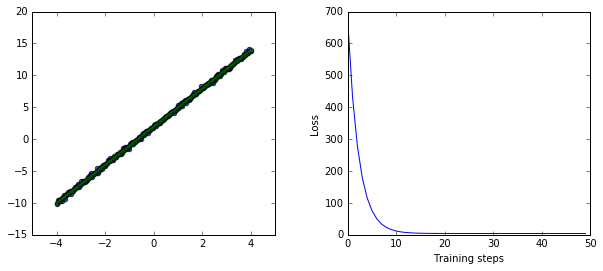

[[ 1.99599552]
 [ 2.99908876]]


In [119]:
num_examples = 200

x = linspace(-4.0,4.0, num_examples)
y = 3.0*x + 2.0 + 0.2*np.random.randn(num_examples)

x_with_bias = np.array([(1.0, a) for a in x]).astype(np.float32)

losses = []
training_steps = 50
learning_rate = 0.001

with tf.Session() as sess:
    input = tf.constant(x_with_bias)
    target = tf.constant(np.transpose([y]).astype(np.float32))
    weights = tf.Variable(tf.random_normal([2,1],
                                           mean=3.0, stddev=1.0))

    tf.initialize_all_variables().run()
    
    yhat = tf.matmul(input, weights)
    yerr = tf.sub(yhat, target)
    
    loss = tf.nn.l2_loss(yerr)
    update_weights = tf.train.GradientDescentOptimizer(learning_rate
                                                     ).minimize(loss)
    
#     loss = 0.5 * tf.reduce_sum(tf.mul(yerr, yerr))
#     gradient = tf.reduce_sum(tf.transpose(tf.mul(input, yerr)),
#                              1, keep_dims=True)
#     update_weights = tf.assign_sub(weights, learning_rate * gradient)
    
    for _ in range(training_steps):
        #update_weights.run()
        sess.run(update_weights)
        losses.append(loss.eval())
        
    betas = weights.eval()
    yhat = yhat.eval()
    
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.subplots_adjust(wspace=.3)
fig.set_size_inches(10, 4)
ax1.scatter(x, y, alpha=.7)
ax1.scatter(x, np.transpose(yhat)[0], c="g", alpha=.6)
line_x_range = (-4, 4)
ax1.plot(line_x_range,
         [betas[0] + a * betas[1] for a in line_x_range], "g", alpha=0.6)
ax2.plot(range(0, training_steps), losses)
ax2.set_ylabel("Loss")
ax2.set_xlabel("Training steps")
plt.show()

print betas

# 3. MNIST 手写数字识别